## Naive Bayes Classifier

In this exercise, I will implement binary NBCs for solving the Kaggle Cats vs. Dogs dataset.

### Data 

Download the dataset from [here](https://www.kaggle.com/c/dogs-vs-cats/data) and unzip it in a subdirectory called `./data/`.

### Model

We will use [torchvision](https://pytorch.org/docs/master/torchvision/) pre-trained ResNet to extract features and train an NBC. Since we have real-valued features, we will use a simple Gaussian distribution to represent the class-conditional density $p(x | y = \text{\{cat,dog\}}, \theta) = \Pi_{j=1}^D \mathcal{N}(x_j | \mu_{jc} , \sigma_{jc}^2)$

In [8]:
import numpy as np
import os
import pandas
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from patsy import dmatrices  # converting Dataframes to usable format

from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

global_params = {
    'batch_size': 1,
    'num_workers': 0,
    'feature_dim': 10
}

In [49]:
class DogsCatsDataset(Dataset):
    def __init__(self, is_train, transform):
        self.is_train = is_train
        self.transform = transform
        if self.is_train:
            self.data_dir = Path("data/catdog/train/")
        else:
            self.data_dir = Path("data/catdog/test1/")
            
    def __len__(self):
        if self.is_train:
            return 25000
        else:
            return 12500
        
    def __getitem__(self, idx):
        if self.is_train:
            if idx > 12499:
                animal = "dog"
                label = 1
            else:
                animal = "cat"
                label = 0
            file_name = animal + ".{}.jpg".format(int(idx % 12500))
            img_name = self.data_dir / file_name
            img = io.imread(img_name)
            img = self.transform(img)
            sample = {'image': img, 'label': label}
            return sample
        else:
            img_name = self.data_dir / "{}.jpg".format(idx+1)
            img = io.imread(img_name)
            img = self.transform(img)
            sample = {'image': img}
            return sample

# Resize image to 256x256, then randomly crop to 224x224,
# then normalize pixel values
dataset = DogsCatsDataset(is_train=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

N = 25000
indices = np.arange(N)
np.random.shuffle(indices)
splitpoint = int(0.9 * N)
train_idx = indices[:splitpoint]
val_idx = indices[splitpoint:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size=global_params['batch_size'],
                         sampler=train_sampler, num_workers=global_params['num_workers'])
val_loader = DataLoader(dataset, batch_size=global_params['batch_size'],
                       sampler=val_sampler, num_workers=global_params['num_workers'])

Before we can run our NBC, lets take a look at applying PCA to the features extracted by the pre-trained resnet18 model, since binary NBC has O(2D) parameters where D is the feature dimension.

In [4]:
from sklearn.decomposition import PCA

gpu = torch.device("cuda:0")
cpu = torch.device("cpu")

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.model = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool
        ) 
        
    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)
    
resnet = ResNet()
resnet = resnet.to(gpu)

In [5]:
# We need to create a 250x512 ndarray,
# where dim1 is samples and sim2 is feature dim
featurized = []
val_labels = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        x = batch['image']
        val_labels.append(batch['label'])
        x = x.to(gpu)
        features = resnet(x)
        featurized.append(features.to(cpu))
X = torch.stack(featurized).squeeze()
val_labels = torch.stack(val_labels).squeeze()

HBox(children=(IntProgress(value=0, max=2500), HTML(value='')))

`X` is a 2500 x 512 torch Tensor that we will now apply PCA

In [6]:
print(X.shape)

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X.numpy())

torch.Size([2500, 512])


PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

[0.02547279 0.01203371 0.00986715 0.00862709 0.00732145 0.00657297
 0.0058737  0.00545661 0.00497204 0.00471083 0.00454205 0.00441003
 0.0043314  0.00423256 0.00419967 0.00418377 0.00411503 0.00407292
 0.00398244 0.003938   0.00391782 0.00388331 0.00386301 0.00380951]


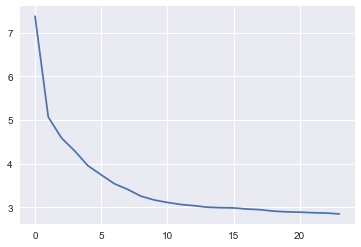

In [7]:
print(pca.explained_variance_ratio_)
plt.plot(pca.singular_values_)

We can try using the top 10 singular values. Now, we can define our NBC and train it with MLE

In [45]:
class GaussianNBC(nn.Module):
    """
    An NBC has O(DC) parameters, where 
    D is the feature dimension and C 
    is the number of classes.  
    
    Here, D = feature_dim and C = 2
    """
    def __init__(self, feature_dim):
        super(GaussianNBC, self).__init__()
        # mean and variance of the Gaussian for each feature 
        # dimension of each class
        self.feature_dim = feature_dim
        # [class, mean, var]
        self.params = torch.zeros(2, 2, feature_dim)
        # uninformative prior
        self.log_priors = torch.log(torch.FloatTensor([0.5])) * torch.ones(2)
        self.eps = torch.FloatTensor([1e-6])
        self.c = torch.log(torch.FloatTensor([2 * np.pi]))
        
    def log_normal(self, x, c):
        """
        compute log-likelihood of x, a [feature_dim] vector
        under N(x | \mu_c, \sigma^2_c)
        
        returns a feature_dim vector of log-likelihoods
        """
        return (-0.5 * (self.c + torch.log(self.params[c, 1, :]))) + \
                       (-0.5 * (1./(self.params[c, 1, :] + self.eps)) * \
                        ((x - self.params[c, 0, :]) ** 2).float())
        
    def forward(self, x):
        """
        x: featurized image to classify after training
        """
        preds = self.log_priors
        p0 = preds[0] + torch.sum(self.log_normal(x, 0))
        p1 = preds[1] + torch.sum(self.log_normal(x, 1))
        return torch.FloatTensor([p0, p1])

In [5]:
pca_train = PCA(n_components=global_params['feature_dim'], svd_solver='randomized')

data = []
labels = []
with torch.no_grad():
    for batch in tqdm(train_loader):
        x = batch['image']
        x = x.to(gpu)
        features = resnet(x)
        data.append(features.to(cpu))
        labels.append(batch['label'])
# 22500 x 512
data = torch.stack(data).squeeze()
# 22500
labels = torch.stack(labels).squeeze()
# 22500 x feature_dim
data_reduced = pca_train.fit_transform(data)
data_reduced = torch.from_numpy(data_reduced).float()

HBox(children=(IntProgress(value=0, max=22500), HTML(value='')))

In [35]:
# Fit the GaussianNBC with MLE
gauss_nbc = GaussianNBC(global_params['feature_dim'])

# the MLE estimate for the parameters given the dataset
# is just the MLE estimate of a Gaussian in each feature dimension, 
# i.e., x_hat_j = 1/N sum_i=1 to N (x_j) and 
# \sigma^2_hat_j = 1/(N-1) sum_i=1 to N (x_j - x_hat_j) ** 2

# select each class using `labels`
#data_reduced = torch.from_numpy(data_reduced).float()
labels = labels.byte()  
flipped_labels = torch.abs(1 - labels)
for j in range(global_params['feature_dim']):
    gauss_nbc.params[1, 0, j] = torch.mean(data_reduced[labels, j])
    gauss_nbc.params[1, 1, j] = torch.var(data_reduced[labels, j])
    gauss_nbc.params[0, 0, j] = torch.mean(data_reduced[flipped_labels, j])
    gauss_nbc.params[0, 1, j] = torch.var(data_reduced[flipped_labels, j])   
    
print(gauss_nbc.params[0,:,:10])
print(gauss_nbc.params[1,:,:10])

tensor(1.00000e-02 *
       [[-0.0034, -6.9734,  0.8322,  1.9554,  0.2579, -0.1051, -0.2677,
         -0.3304, -0.0927,  0.0387],
        [ 2.1051,  0.3843,  0.7289,  0.7536,  0.4674,  0.4535,  0.4121,
          0.3521,  0.3493,  0.3245]])
tensor(1.00000e-02 *
       [[ 0.0034,  6.9796, -0.8329, -1.9571, -0.2581,  0.1052,  0.2679,
          0.3307,  0.0928, -0.0387],
        [ 2.0516,  0.5936,  0.9105,  0.5983,  0.7168,  0.5998,  0.5271,
          0.4892,  0.3847,  0.3363]])


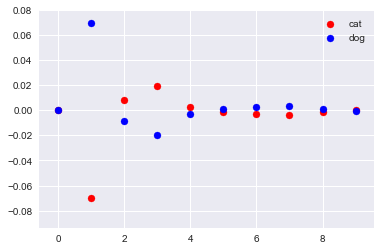

In [38]:
def plot_data(model, label1='cat', label2='dog', d=None, y=None):
    plt.figure()
    plt.scatter(np.arange(global_params['feature_dim']), model.params[0,0].numpy(), c='r', label=label1)
    plt.scatter(np.arange(global_params['feature_dim']), model.params[1,0].numpy(), c='b', label=label2)
    if d is not None and y is not None:
        plt.scatter(np.arange(global_params['feature_dim']), d, c='g', label=y)
    plt.legend()
    plt.show()
    
plot_data()

Let's compute the training accuracy

In [37]:
num_correct = 0
N = 22500
labels = labels.long()
with torch.no_grad():
    for idx in tqdm(range(N)):
        x = data_reduced[idx]
        y = labels[idx]
        _, pred = torch.max(gauss_nbc(x), 0)
        if pred == y:
            num_correct += 1
print("Gaussian NBC training accuracy: {} %".format(num_correct / N))

HBox(children=(IntProgress(value=0, max=22500), HTML(value='')))


Gaussian NBC training accuracy: 0.5004 %


Simple Guassian NBC is not able to do much with this dataset! :( Not too surprising.
Just to see what happens, lets train LogReg on the full featurized dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(data, labels)

In [ ]:
training_accuracy = logreg.score(data, labels)
print('logreg training accuracy: {} %'.format(training_accuracy))

In [ ]:
print('logreg validation accuracy: {} %'.format(logreg.score(X, val_labels)))

## Titanic dataset

Let's try a simpler dataset so we can get actual interesting results out of our Gaussian NBC

In [10]:
# Preprocess the dataset
df = pandas.read_csv(Path('data/titanic/train.csv'))
# Throw out the name
df = df.drop(['Cabin', 'Ticket'], axis=1)

In [11]:
df = df.dropna()

In [12]:
def min_max_scaling(x, upper, lower):
    y = (x - x.min()) / (x.max() - x.min())
    return y * (upper - lower) + lower

# normalize entries
df['Pclass'] = df['Pclass'].astype('category').cat.codes
df['Pclass'] = min_max_scaling(df['Pclass'],-1,1)
df['Sex'] = df['Sex'].astype('category').cat.codes
df['Sex'] = min_max_scaling(df['Sex'],-1,1)
#df['Age'] = df['Age'].astype('category').cat.codes
#df['Age'] = min_max_scaling(df['Age'],-1,1)
df['SibSp'] = df['SibSp'].astype('category').cat.codes
df['SibSp'] = min_max_scaling(df['SibSp'],-1,1)
#df['Parch'] = df['Parch'].astype('category').cat.codes
#df['Parch'] = min_max_scaling(df['Parch'],-1,1)
#df['Fare'] = df['Fare'].astype('category').cat.codes
#df['Fare'] = min_max_scaling(df['Fare'],-1,1)
df['Embarked'] = df['Embarked'].astype('category').cat.codes
df['Embarked'] = min_max_scaling(df['Embarked'],-1,1)

In [13]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,-1.0,"Braund, Mr. Owen Harris",-1.0,22.0,0.6,0,7.2500,-1.0
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,38.0,0.6,0,71.2833,1.0
2,3,1,-1.0,"Heikkinen, Miss. Laina",1.0,26.0,1.0,0,7.9250,-1.0
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,35.0,0.6,0,53.1000,-1.0
4,5,0,-1.0,"Allen, Mr. William Henry",-1.0,35.0,1.0,0,8.0500,-1.0
6,7,0,1.0,"McCarthy, Mr. Timothy J",-1.0,54.0,1.0,0,51.8625,-1.0
7,8,0,-1.0,"Palsson, Master. Gosta Leonard",-1.0,2.0,-0.2,1,21.0750,-1.0
8,9,1,-1.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1.0,27.0,1.0,2,11.1333,-1.0
9,10,1,0.0,"Nasser, Mrs. Nicholas (Adele Achem)",1.0,14.0,0.6,0,30.0708,1.0
10,11,1,-1.0,"Sandstrom, Miss. Marguerite Rut",1.0,4.0,0.6,1,16.7000,-1.0


In [15]:
df = df.drop(['Name', 'PassengerId', 'Parch'], axis=1)
df

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0,-1.0,-1.0,22.0,0.6,7.2500,-1.0
1,1,1.0,1.0,38.0,0.6,71.2833,1.0
2,1,-1.0,1.0,26.0,1.0,7.9250,-1.0
3,1,1.0,1.0,35.0,0.6,53.1000,-1.0
4,0,-1.0,-1.0,35.0,1.0,8.0500,-1.0
6,0,1.0,-1.0,54.0,1.0,51.8625,-1.0
7,0,-1.0,-1.0,2.0,-0.2,21.0750,-1.0
8,1,-1.0,1.0,27.0,1.0,11.1333,-1.0
9,1,0.0,1.0,14.0,0.6,30.0708,1.0
10,1,-1.0,1.0,4.0,0.6,16.7000,-1.0


In [46]:
data = torch.from_numpy(df.values).float()
feature_dim = data.shape[1]-1
gauss_nbc_ = GaussianNBC(feature_dim=feature_dim)

survived_mask = (data[:,0] == 1)
dead_mask = (data[:,0] == 0)

# Set the priors
prior_survived = torch.sum(survived_mask).float() / data.shape[0]
prior_dead = torch.sum(dead_mask).float() / data.shape[0]

gauss_nbc_.log_priors = torch.log(torch.FloatTensor([prior_dead.item(), prior_survived.item()]))
print(gauss_nbc_.log_priors)

tensor([-0.5183, -0.9051])


In [47]:
for j in range(feature_dim):
    # survived = 1
    gauss_nbc_.params[1, 0, j] = torch.mean(data[survived_mask][:, j+1])
    gauss_nbc_.params[1, 1, j] = torch.var(data[survived_mask][:, j+1])
    # survived = 0
    gauss_nbc_.params[0, 0, j] = torch.mean(data[dead_mask][:, j+1])
    gauss_nbc_.params[0, 1, j] = torch.var(data[dead_mask][:, j+1])
    
print(gauss_nbc_.params[0,0,:])
print(gauss_nbc_.params[1,0,:])

tensor([ -0.4858,  -0.6981,  30.6262,   0.7896,  22.9655,  -0.7123])
tensor([  0.1215,   0.3542,  28.1933,   0.8014,  51.6477,  -0.4236])


In [48]:
# Training set accuracy
num_correct = 0
N = data.shape[0]
logprobs = 0
with torch.no_grad():
    for idx in tqdm(range(N)):
        x = data[idx,1:]
        y = data[idx,0].long()
        p, pred = torch.max(gauss_nbc_(x), 0)
        if pred == y_:
            num_correct += 1
        logprobs += p
print("Gaussian NBC training accuracy: {} %".format(num_correct / N))
print("average log-likelihood: {}".format(logprobs / N))

Gaussian NBC training accuracy: 0.6081460674157303 %
average log-likelihood: -13.337108612060547


That's better than random! For funsies let's also overfit the dataset with a decision tree

In [51]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data[:, 1:], data[:,0])

print("Decision tree training accuracy: {} %".format(clf.score(data[:, 1:], data[:,0])))

Decision tree training accuracy: 0.9859550561797753 %
